In [250]:
## BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import pickle as cp
import scipy.optimize as opt
from scipy.optimize import curve_fit as fit
#import mps
import cProfile
import subprocess
from scipy.special import hyp2f1, erf
from scipy.optimize import brentq
from matplotlib import cm
cmap = cm.get_cmap("tab20")
import itertools

# A test of $\epsilon$-expansion in 1D 

An obvious criticism of the $\epsilon$ expansion is that a field theoy in $(4 - \epsilon)$ does not exist. Besides, doing numerics in 3D is quite hard. Here, we shall study an Ising model in a 1D lattice, but with long range interations which are designed to mimic any dimension $D$ (even non-integer ones!), while being easily accessible numerically. The goal is to test predictions of the perturbative RG with $\epsilon$ truly small. 

The microscopic Hamiltonian has the form
$$ 
 H = \sum_{i < j} J_{|i - j|} \sigma_i \sigma_j
$$

A first natural idea is to take a power-law interaction:
$$ 
 J_{r} \propto r^{-1-\alpha} 
$$

- Argue, à la Laudau-Ginzburg, that this model is described by a field theory in 1D with long range "elastic" energy
$$ \int_x \left[ g_2 \phi^2 + g_4 \phi^4 +  \dots \right] + \frac12 \int_q |\hat{\phi}(q)|^2 |q|^{\alpha} $$
- Argue that mean field theory is valid for 
$$ \alpha < 1/2 $$
So we will be doing an expansion 
$$\epsilon = \alpha - 1/2 $$
- What is the bare scaling dimension of $\phi$?
- Write down the one-loop RG flow equations for $g_2$ and $g_4$. Copy as much as we can.
- Compute the correlation length exponent $\nu = 1/y_T$ to order $\epsilon$. 

###  "Dyadic" long range model 

We are going to compare the above prediction to numerics. Universality invites us to take a further step in reducing the numerical cost. Instead of having spins interact at all distances, we let them interact only if the distance is a power of $2$:

$$ J_{r} \propto \begin{cases} r^{-\alpha} &  r = 2^k   \\ 0 & \text{otherwise}
 \end{cases}  $$
  
- Why do we still expect the model to be described by the above field theory?
 
In the numerics below we use the Swendsen-Wang algorithm, which works with the variable $w_r = 1-e^{-2J_r} \sim 2 J_r + O(J_r^2)$ for small coupling. So we can we take

$$ w_{2^k} = K \, 2^{-k\alpha} \,,\, k = 0, 1, 2, \dots   $$

$K$ would be the tuning parameter. 



### A numerical tool: Binder ratio

To save effort, we want to study exclusively $\nu$ (and not the spin scaling dimension $\Delta_\sigma$). This is not obvious since observables involving spin usually involves $\Delta_\sigma$ as well. A clever numerical trick is found by Binder to overcome this. Consider 

$$ B = 1 - \frac{\left< m^4 \right>}{3 \left< m^2 \right>} $$

where $m =( \sum_i \sigma_i  ) / L$ is the average magnetization of the system, and the average is over the Gibbs ensemble. 

- Argue that in the thermodynamic limit $B\to 2/3$ in the symmetry broken phase
- Argue that $B \to 0$ in the high temperature phase (hint: what is $m$ is Gaussian).
- Argue that near criticality, 

$$ B = B( |T-T_c| L^{y_T}) , $$

that is, its critical scaling does not involve $\Delta_{\psi}$

### Note

The critical value is unknown and non-universal. The code below "works" for $\alpha = .75$ because I tested it and found the critical point a range of system sizes that work decently. For other values you need to adjust all that.

In [270]:
res_binder = dict()

In [275]:
Ks = np.linspace(.4, .6, 10)
alpha = .75
for lb in [6,8,10]:
   
    L = 2 ** lb
    print("L = %d" % L, end = "K = ")

    data = np.ones(L* lb, dtype=int)
    Is = np.arange(L * lb, dtype=int) // lb
    Js = (Is + 2 ** (np.arange(L * lb, dtype=int) % lb)) % L
    edges = sp.coo_matrix((data, (Is, Js)), shape=(L,L))
    spin = np.zeros(L, dtype=int)

    for K in Ks:
        print("%g" % K, end = ", ")
        ws = 2 ** (np.arange(lb) * -alpha) * K
        if not (alpha, K, lb) in res_binder:
            res_binder[alpha, K, lb] = (np.array([0.,0., 0.]), spin)
        else:
            spin = res_binder[alpha, K, lb][1]
        for j in range(200):

            same = np.where(spin[edges.row] == spin[edges.col])[0]  

            edges.data[:] = 0
            edges.data[same] = (rnd.rand(len(same)) < ws[same % lb]) # same color: throw a dice

            FK_graph = edges.tocsc()
            FK_graph.eliminate_zeros()
            n_cl, FK_clusters = sp.csgraph.connected_components(FK_graph, directed=0, return_labels=1)

            FK_spin = rnd.randint(2, size = n_cl) * 2 - 1
            spin[:] = FK_spin[FK_clusters]

            O = np.mean(spin)
            res_binder[alpha, K,lb][0][:] += [1, O**2, O**4]

L = 64K = 0.4, 0.422222, 0.444444, 0.466667, 0.488889, 0.511111, 0.533333, 0.555556, 0.577778, 0.6, L = 256K = 0.4, 0.422222, 0.444444, 0.466667, 0.488889, 0.511111, 0.533333, 0.555556, 0.577778, 0.6, L = 1024K = 0.4, 0.422222, 0.444444, 0.466667, 0.488889, 0.511111, 0.533333, 0.555556, 0.577778, 0.6, 

prediction: 1/\nu = 0.33333333333333337


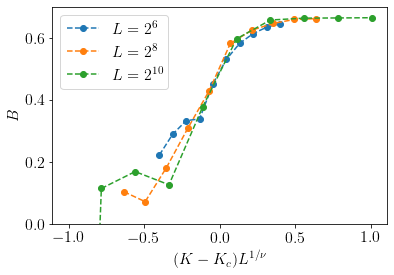

In [274]:
alpha = .75
for lb in [6,8,10]:
    res = []
    for K in Ks:
        data = res_binder[alpha, K, lb][0]
        binder = 1 - (data[2] / data[0]) / (data[1] / data[0]) ** 2 / 3
        res.append(binder )
        
    L = 2 ** lb
    yT = .5 - (alpha - 1/2) * 2/3
    plt.plot((Ks - .50) * L ** (yT) , res , "o--", label=r"$L = 2^{%d}$" % lb)
plt.ylim(0,.7)
print(r"prediction: 1/\nu =", yT)
plt.xlabel(r"$(K-K_c)  L^{1/\nu}$")
plt.ylabel(r"$B$")
plt.legend()

### Check that the dyadic hopping produces a correct low momenta behavior

Text(0, 0.5, '$|q|^{\\alpha}$')

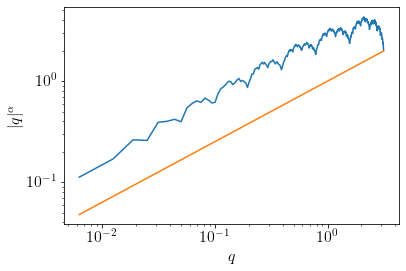

In [257]:
qs = np.linspace(0, np.pi, 500)
alpha = .6
ans = np.zeros(len(qs), dtype=float)
for k in range(10):
    ans += np.cos( 2 ** k * qs) * (2**(-k*alpha))
plt.loglog(qs[1:], ans[0] - ans[1:])
plt.loglog(qs[1:], qs[1:] ** alpha)
plt.xlabel(r"$q$")
plt.ylabel(r"$|q|^{\alpha}$")